In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [2]:
dataset_path = "../../../../OneDrive - King\'s College London/PhD/schizophrenia_data/dataset/"
preprocessed_dataset_path = "../../../../OneDrive - King\'s College London/PhD/schizophrenia_data/preprocessed_dataset/"

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import nibabel as nib

In [5]:
Imperial_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                               sheet_name='IMPERIAL ROIs LEGEND',
                               header=None).drop([0,1],axis=1)
Imperial_label.to_csv('./Imperial_label.txt',index=False,header=False)

In [6]:
Imperial_label = pd.read_csv('./Imperial_label.txt',header=None)
Imperial_label = Imperial_label.iloc[:,0].to_list()

In [7]:
from collections import defaultdict

Imperial_label_dict = defaultdict(dict)

for connection in Imperial_label:
    number = int([i for i in connection.split(' ') if i.isdigit()][0]) # get the number
    temp_connection = connection.strip(str(number)).strip()
    if 'left' in temp_connection:
        Imperial_label_dict[number]['Orientation'] = 'left'
        temp_connection = temp_connection.replace('left','').strip()
    elif 'right' in temp_connection:
        Imperial_label_dict[number]['Orientation'] = 'right'
        temp_connection = temp_connection.replace('right','').strip()
    else:
        Imperial_label_dict[number]['Orientation'] = 'None'
    if 'GM' in temp_connection:
        Imperial_label_dict[number]['matter'] = 'GM'
        temp_connection = temp_connection.replace('GM','').strip()
    elif 'WM' in temp_connection:
        Imperial_label_dict[number]['matter'] = 'WM'
        temp_connection = temp_connection.replace('WM','').strip()
    else:
        Imperial_label_dict[number]['matter'] = 'None'
    temp_connection = temp_connection.split(' ')
    try:
        part_index = temp_connection.index('part')
        Imperial_label_dict[number]['part'] = temp_connection[part_index-1]
        temp_connection.remove(temp_connection[part_index-1])
        temp_connection.remove('part')
    except ValueError:
        Imperial_label_dict[number]['part'] = 'None'
    temp_connection = ' '.join(temp_connection)
    Imperial_label_dict[number]['Name'] = temp_connection.strip()
    if Imperial_label_dict[number]['Name'][-1] == ',':
        Imperial_label_dict[number]['Name'] = temp_connection.replace(',','')
    
    if len(Imperial_label_dict[number]['Name'].split(' ')) > 1:
        Imperial_label_dict[number]['abbr'] = ''.join([word[0] for word in Imperial_label_dict[number]['Name'].split(' ')]).upper()
    else:
        Imperial_label_dict[number]['abbr'] = Imperial_label_dict[number]['Name'][:4].upper()
    
    if Imperial_label_dict[number]['matter'] != 'None':
        Imperial_label_dict[number]['Name_and_matter'] = '.'.join([Imperial_label_dict[number]['abbr'],Imperial_label_dict[number]['matter']])
    else:
        Imperial_label_dict[number]['Name_and_matter'] = Imperial_label_dict[number]['abbr']
        
    
    if Imperial_label_dict[number]['part']!= 'None':
        Imperial_label_dict[number]['abbr'] = ' '.join([Imperial_label_dict[number]['part'],Imperial_label_dict[number]['abbr']])
    if Imperial_label_dict[number]['matter'] != 'None':
        Imperial_label_dict[number]['abbr'] = '.'.join([Imperial_label_dict[number]['abbr'],Imperial_label_dict[number]['matter']])
        
    if Imperial_label_dict[number]['Orientation'] != 'None':
        Imperial_label_dict[number]['abbr'] = '.'.join([Imperial_label_dict[number]['Orientation'][0].upper(),Imperial_label_dict[number]['abbr']])
        Imperial_label_dict[number]['Name_and_matter'] = '.'.join([Imperial_label_dict[number]['Orientation'][0].upper(),Imperial_label_dict[number]['Name_and_matter']])
        
Imperial_label_dict_regions = [Imperial_label_dict[number]['abbr'] for number in range(1,88)]

In [8]:
# white_matter_labels       = 51..82              # tissues: 3
# gray_matter_labels        = 5..16,20..39        # tissues: 2
# deep_gray_matter_labels   = 1..4,40..47,85..87  # tissues: 5,7,9
# lateral_ventricles_labels = 49,50
# corpus_callosum_labels    = 48
# inter_hemisphere_labels   = 40..47,85..87
# brainstem_labels          = 19
# cerebellum_labels         = 17,18


In [9]:
white_matter_labels = list(range(51,83))
grey_matter_labels = list(range(5,17)) + list(range(20,40))
deep_grey_matter_labels = list(range(1,5)) + list(range(40,48)) + list(range(85,88))
lateral_ventricles_labels = [49,50]
corpus_callosum_labels = [48]
brainstem_labels = [19]
cerebellum_labels = [17,18]
csf_labels = [83]
background_labels = [84,85]
interhemispheric_labels = list(range(40,48)) + list(range(85,88))

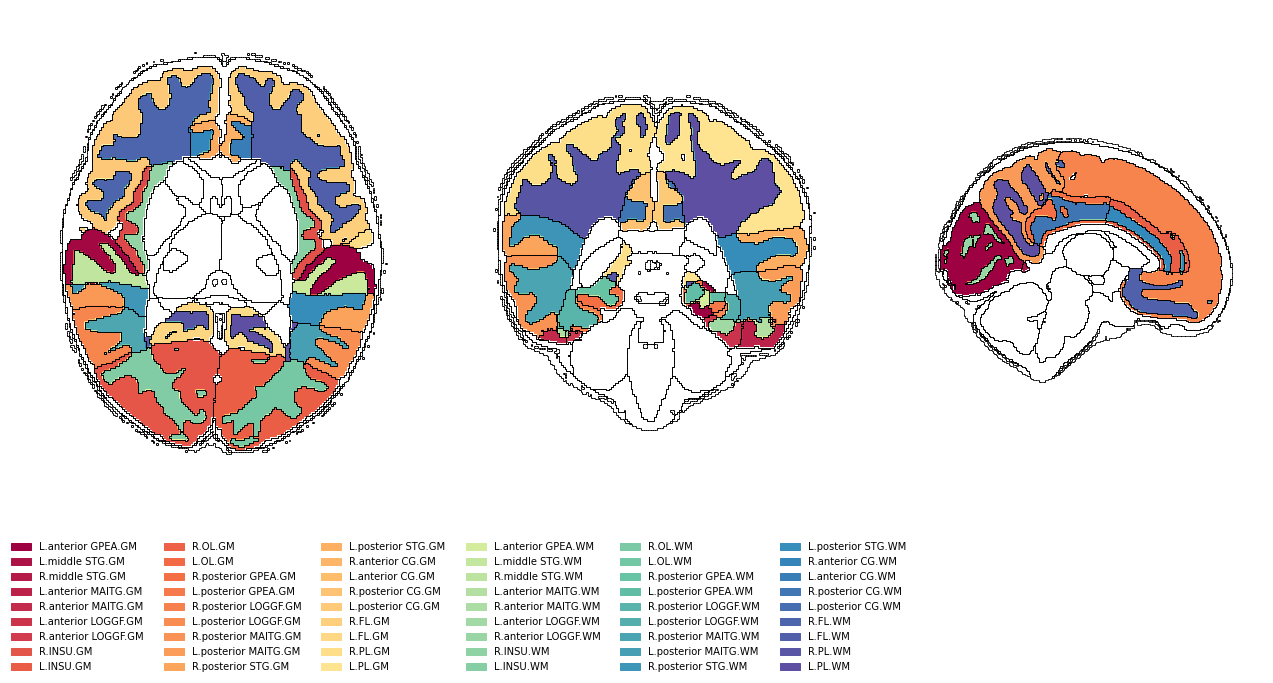

In [10]:
FOLDER_PATH = f'{dataset_path}/visualise/Imperial/'  # please change to your own path

atlas_file = nib.load(FOLDER_PATH + 'atlas_t40.nii.gz')
atlas_aff = atlas_file.affine
atlas = atlas_file.get_fdata()

import copy
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches

cmap = copy.copy(plt.cm.get_cmap('Spectral'))
cmap.set_bad(alpha=0)

atlas[atlas == 0] = np.nan
original_axial_atlas = atlas[:,:,atlas.shape[2]//2].copy()
original_coronal_atlas = atlas[:,atlas.shape[2]//2,:].copy()
original_sagittal_atlas = atlas[atlas.shape[2]//2,:,:].copy()

for region in lateral_ventricles_labels + corpus_callosum_labels + brainstem_labels + cerebellum_labels + csf_labels + background_labels + deep_grey_matter_labels:
    atlas[atlas == region] = np.nan


# for uniq_region in list(set(Imperial_label_dict_regions)):
#     regions = [k for k in Imperial_label_dict.keys() if Imperial_label_dict[k]['abbr'] == uniq_region]
#     if len(regions)==2:
#         atlas[atlas == regions[0]] = regions[1]
#     if len(regions)>2:
#         print(uniq_region)


        
axial_atlas = atlas[:,:,atlas.shape[2]//2].copy()
coronal_atlas = atlas[:,atlas.shape[2]//2,:].copy()
sagittal_atlas = atlas[atlas.shape[2]//2,:,:].copy()


fig,axes = plt.subplots(1,3,figsize=(22,10))

axial_view = axes[0]
coronal_view = axes[1]
sagittal_view = axes[2]

im1 = axial_view.imshow(np.rot90(axial_atlas),cmap=cmap)
im2 = coronal_view.imshow(np.rot90(coronal_atlas),cmap=cmap)
im3 = sagittal_view.imshow(np.rot90(sagittal_atlas),cmap=cmap)


values = np.unique(np.concatenate([axial_atlas.ravel(),
                                   coronal_atlas.ravel(),
                                   sagittal_atlas.ravel()]))
values = values[~np.isnan(values)]

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im2.cmap(im2.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=colors[i], label=Imperial_label_dict[int(values[i])]['abbr']) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(-2.5, -1,0,0), loc='lower left',ncol=6,frameon=False)

for new_atlas, view in zip([original_axial_atlas,original_coronal_atlas,original_sagittal_atlas],
                      [axial_view,coronal_view,sagittal_view]):
    for i in np.unique(new_atlas[~np.isnan(new_atlas)]):
        temp_atlas = new_atlas.copy()
        temp_atlas[temp_atlas != i] = 0
        temp_atlas[temp_atlas == i] = 1
        temp_line = LineCollection(visualisation.get_edges(np.rot90(temp_atlas)),lw=1,color='k')
        view.add_collection(temp_line)

for ax in axes:
    sns.despine(bottom=True,left=True,right=True)
    ax.set_xticks([])
    ax.set_yticks([])

# fig.savefig(f'{preprocessed_dataset_path}/output_plot/all_segmentations.svg', bbox_inches='tight')
fig.savefig(f'./all_segmentations.svg', bbox_inches='tight')

In [11]:
Imperial_label_dict_regions = [Imperial_label_dict[number]['Name_and_matter'] for number in range(1,88)]

In [12]:
for uniq_region in list(set(Imperial_label_dict_regions)):
    name_regions = [k for k in Imperial_label_dict.keys() if Imperial_label_dict[k]['Name_and_matter'] == uniq_region]
    for region in name_regions:
        atlas[atlas == region] = name_regions[0]


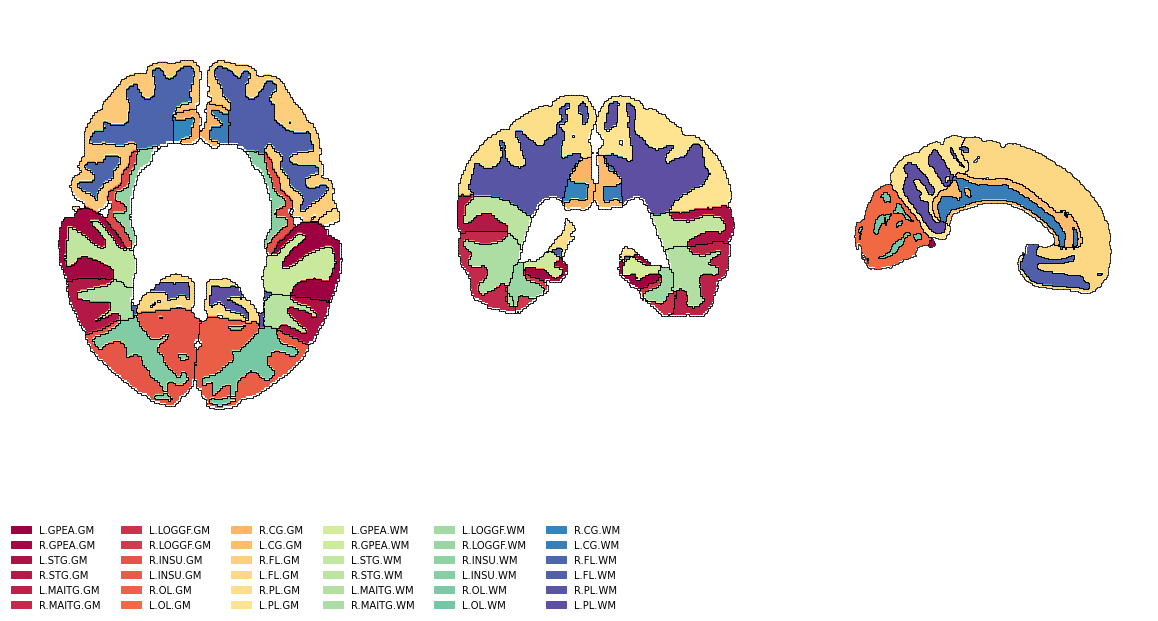

In [13]:
FOLDER_PATH = f'{dataset_path}/visualise/Imperial/'  # please change to your own path

atlas_file = nib.load(FOLDER_PATH + 'atlas_t40.nii.gz')
atlas_aff = atlas_file.affine
atlas = atlas_file.get_fdata()

import copy
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches

cmap = copy.copy(plt.cm.get_cmap('Spectral'))
cmap.set_bad(alpha=0)

atlas[atlas == 0] = np.nan


for region in lateral_ventricles_labels + corpus_callosum_labels + brainstem_labels + cerebellum_labels + csf_labels + background_labels + deep_grey_matter_labels:
    atlas[atlas == region] = np.nan


for uniq_region in list(set(Imperial_label_dict_regions)):
    name_regions = [k for k in Imperial_label_dict.keys() if Imperial_label_dict[k]['Name_and_matter'] == uniq_region]
    if len(name_regions)>1:
        for region in name_regions:
            atlas[atlas == region] = name_regions[0]

original_axial_atlas = atlas[:,:,atlas.shape[2]//2].copy()
original_coronal_atlas = atlas[:,atlas.shape[2]//2,:].copy()
original_sagittal_atlas = atlas[atlas.shape[2]//2,:,:].copy()
            
axial_atlas = atlas[:,:,atlas.shape[2]//2].copy()
coronal_atlas = atlas[:,atlas.shape[2]//2,:].copy()
sagittal_atlas = atlas[atlas.shape[2]//2,:,:].copy()


fig,axes = plt.subplots(1,3,figsize=(20,10))

axial_view = axes[0]
coronal_view = axes[1]
sagittal_view = axes[2]

im1 = axial_view.imshow(np.rot90(axial_atlas),cmap=cmap)
im2 = coronal_view.imshow(np.rot90(coronal_atlas),cmap=cmap)
im3 = sagittal_view.imshow(np.rot90(sagittal_atlas),cmap=cmap)


values = np.unique(np.concatenate([axial_atlas.ravel(),
                                   coronal_atlas.ravel(),
                                   sagittal_atlas.ravel()]))
values = values[~np.isnan(values)]

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im2.cmap(im2.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=colors[i], label=Imperial_label_dict[int(values[i])]['Name_and_matter']) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(-2.5, -1,0,0), loc='lower left',ncol=6,frameon=False)

for new_atlas, view in zip([original_axial_atlas,original_coronal_atlas,original_sagittal_atlas],
                      [axial_view,coronal_view,sagittal_view]):
    for i in np.unique(new_atlas[~np.isnan(new_atlas)]):
        temp_atlas = new_atlas.copy()
        temp_atlas[temp_atlas != i] = 0
        temp_atlas[temp_atlas == i] = 1
        temp_line = LineCollection(visualisation.get_edges(np.rot90(temp_atlas)),lw=1,color='k')
        view.add_collection(temp_line)

for ax in axes:
    sns.despine(bottom=True,left=True,right=True)
    ax.set_xticks([])
    ax.set_yticks([])

# fig.savefig(f'{preprocessed_dataset_path}/output_plot/combined_segmentations.svg', bbox_inches='tight')
fig.savefig(f'./combined_segmentations.svg', bbox_inches='tight')